In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import time
import os
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import (
    mean_squared_error,       
    mean_absolute_error,      
    r2_score,                
    mean_absolute_percentage_error,  
    mean_squared_log_error    # MSLE
)
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


In [2]:
df_raw= pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv", low_memory=False)
df = df_raw.copy()


# Feature engineering

In [3]:
df = pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv",low_memory=False)
df.drop(['gender', 'balls_per_over', 'series_name', 'name_x', 'name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams'], axis = 1, inplace = True)
df['all_rounder_score'] = (df['runs_scored']/90 + df['wickets_taken']*0.35)*20
df['fielding'] = (df['catches_taken'] * 5 + df['run_out_throw'] * 15 + df['run_out_direct'] * 4)
df['batting_impact'] = ((2 * df['sixes_scored'].fillna(0) + df['fours_scored'].fillna(0)) /df['balls_faced'].replace(0, np.nan)).fillna(0)

df['bowling_impact'] = ( (3 * df['wickets_taken'].fillna(0) + df['dot_balls_as_bowler'].fillna(0)) / df['balls_bowled'].replace(0, np.nan)).fillna(0)

# LABEL ENCODING CATEROGICAL OR MULTI CLASS COLUMNS
label_encoder = LabelEncoder()

df['player_id'] = label_encoder.fit_transform(df['player_id'].fillna("Unknown"))
df['match_type'] = df['match_type'].fillna("Unknown")
df = pd.get_dummies(df, columns = ['match_type'], drop_first = True, dtype=int)

df['player_team'] = label_encoder.fit_transform(df['player_team'].fillna("Unknown"))
df['opposition_team'] = label_encoder.fit_transform(df['opposition_team'].fillna("Unknown"))

df




,player_id,match_id,start_date,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,run_out_direct,...,fantasy_score_total,all_rounder_score,fielding,batting_impact,bowling_impact,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,922,1158348,21-08-2018,10,1,30,1,0,1,0,...,17,2.222222,5,0.033333,0.0,0,0,0,1,0
1,922,1182644,05-05-2019,8,1,18,1,0,0,0,...,7,1.777778,0,0.055556,0.0,0,0,0,1,0
2,922,1275107,09-09-2021,1,0,5,0,0,0,0,...,5,0.222222,0,0.000000,0.0,0,0,0,1,0
3,922,1275113,15-09-2021,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0
4,922,1275125,14-09-2021,1,1,15,0,0,0,0,...,-1,0.222222,0,0.000000,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,11770,1473475,20-04-2025,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0
416708,11770,1473478,23-04-2025,0,0,0,0,0,1,0,...,12,0.000000,5,0.000000,0.0,0,0,0,1,0
416709,11770,1473482,27-04-2025,25,0,13,2,2,1,0,...,49,5.555556,5,0.461538,0.0,0,0,0,1,0
416710,11770,1473487,01-05-2025,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0


In [4]:
print(df.columns.tolist())

['player_id', 'match_id', 'start_date', 'runs_scored', 'player_out', 'balls_faced', 'fours_scored', 'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled', 'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens', 'dot_balls_as_bowler', 'player_team', 'opposition_team', 'fantasy_score_batting', 'fantasy_score_bowling', 'fantasy_score_total', 'all_rounder_score', 'fielding', 'batting_impact', 'bowling_impact', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test']


# Splitting the dataset for training and testing purpose

In [5]:
def split(df,date):
    train = df[df['start_date']< pd.to_datetime(date)]
    test = df[df['start_date']>= pd.to_datetime(date)]
    return train,test

df['start_date'] = pd.to_datetime(df['start_date'])
df_train, df_test = split(df, pd.to_datetime('2024-12-01'))

df_train.sort_values(by='start_date')
df_test.sort_values(by='start_date')

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

C:\Users\abhau\AppData\Local\Temp\ipykernel_25660\464633085.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_date'] = pd.to_datetime(df['start_date'])


In [6]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Generating rolling-window stats of past few games to analyze recent form

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Rolling stats function
def rolling_stats(group):
    group = group.sort_values('start_date')

    balls_faced = group['balls_faced'].replace(0, np.nan).astype(float)
    balls_bowled = group['balls_bowled'].replace(0, np.nan).astype(float)

    group['SR_match'] = (group['runs_scored'] / balls_faced) * 100
    group['ECO_match'] = group['runs_conceded'] / (balls_bowled / 6)

    group['SR_match'] = group['SR_match'].replace([np.inf, -np.inf], np.nan).clip(upper=300).fillna(0)
    group['ECO_match'] = group['ECO_match'].replace([np.inf, -np.inf], np.nan).clip(upper=20).fillna(0)

    group['strike_rate_1'] = group['SR_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['strike_rate_5'] = group['SR_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['strike_rate_10'] = group['SR_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['economy_rate_1'] = group['ECO_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['economy_rate_5'] = group['ECO_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['economy_rate_10'] = group['ECO_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['fours_1'] = group['fours_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['fours_5'] = group['fours_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['fours_10'] = group['fours_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['sixes_1'] = group['sixes_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['sixes_5'] = group['sixes_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['sixes_10'] = group['sixes_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['AR_1'] = group['all_rounder_score'].shift(1).rolling(window=1, min_periods=1).mean() * 10
    group['AR_5'] = group['all_rounder_score'].shift(1).rolling(window=5, min_periods=1).mean() * 10
    group['AR_10'] = group['all_rounder_score'].shift(1).rolling(window=10, min_periods=1).mean() * 10

    group['fantasy_1'] = group['fantasy_score_total'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasy_5'] = group['fantasy_score_total'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasy_10'] = group['fantasy_score_total'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasy_15'] = group['fantasy_score_total'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybat_1'] = group['fantasy_score_batting'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybat_5'] = group['fantasy_score_batting'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybat_10'] = group['fantasy_score_batting'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybat_15'] = group['fantasy_score_batting'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybowl_1'] = group['fantasy_score_bowling'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybowl_5'] = group['fantasy_score_bowling'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybowl_10'] = group['fantasy_score_bowling'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybowl_15'] = group['fantasy_score_bowling'].shift(1).rolling(window=15, min_periods=9).sum()

    group['runs_scored_5'] = group['runs_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['runs_scored_10'] = group['runs_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['wickets_taken_5'] = group['wickets_taken'].shift(1).rolling(window=5, min_periods=2).sum()
    group['wickets_taken_10'] = group['wickets_taken'].shift(1).rolling(window=10, min_periods=5).sum()

    return group

#Weighted Moving Average features
def apply_wma_features(df, span=5, w=1.7):
    df = df.copy()
    base_weights = np.array([w**(span - i - 1) for i in range(span)])
    base_weights /= base_weights.sum()

    wma_cols = {
        'runs_scored': 'runs_scored_wma',
        'SR_match': 'SR_match_wma',
        'ECO_match': 'ECO_match_wma',
        'fantasy_score_batting': 'fantasybat_wma',
        'fantasy_score_bowling': 'fantasybowl_wma',
        'batting_impact': 'bat_wma',
        'bowling_impact':'bowl_wma',
        'fantasy_score_total': 'fantasy_wma'
    }

    for col, new_col in wma_cols.items():
        if col in df.columns:
            def wma_func(x):
                def weighted_rolling(arr):
                    L = len(arr)
                    if L == 0:
                        return np.nan
                    weights = base_weights[-L:]  # trim weights
                    weights /= weights.sum()     # normalize
                    return np.dot(arr, weights)
                return x.shift(1).rolling(window=span, min_periods=2).apply(weighted_rolling, raw=True)

            df[new_col] = df.groupby('player_id')[col].transform(wma_func)
        else:
            print(f"[WMA] Column '{col}' missing in DataFrame.")

    return df

df_stats = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)

df_stats = apply_wma_features(df_stats, span=5)

def player_features(data):
    feature_data = []

    for player_id, group in data.groupby(['player_id']):
        group = group.sort_values('start_date')
        group = rolling_stats(group)
        group = apply_wma_features(group, span=5)
        feature_data.append(group)

    result_df = pd.concat(feature_data).reset_index(drop=True)

    return result_df[[
        'player_id', 'match_id', 'match_type', 'start_date', 'fantasy_score_total',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15','fantasybowl_10','fantasybowl_5','fantasybat_10','fantasybat_5', 'strike_rate_5', 'strike_rate_10', 'economy_rate_10',
        'fours_10','sixes_10', 'AR_5', 'AR_10','bat_wma','bowl_wma','fantasy_wma',
        'runs_scored_5', 'runs_scored_10',
        'wickets_taken_5', 'wickets_taken_10',
        'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',
        'fantasybat_wma', 'fantasybowl_wma',  'order_seen']]
    

100%|██████████| 11771/11771 [08:43<00:00, 22.50it/s] 


In [8]:
from tqdm import tqdm
tqdm.pandas() 
def get_features_all_players(df):
    #  Apply rolling stats and WMA features
    df_feat = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)
    df_feat = apply_wma_features(df_feat, span=5)

    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill only numeric columns
    numeric_cols = df_feat.select_dtypes(include='number').columns
    df_feat[numeric_cols] = df_feat[numeric_cols].fillna(0)

    
    match_type_cols = [col for col in df_feat.columns if col.startswith("match_type_")]

   
    selected_cols = [
        'player_id', 'match_id', 'start_date', 'fantasy_score_total',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',  'fantasybowl_10', 'fantasybowl_5',
        'fantasybat_10', 'fantasybat_5','strike_rate_5', 'strike_rate_10', 'economy_rate_10','bat_wma','bowl_wma','fantasy_wma',
        'fours_10', 'sixes_10', 'AR_5', 'AR_10',  'runs_scored_5', 'runs_scored_10',
        'wickets_taken_5', 'wickets_taken_10',  'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',
        'fantasybat_wma', 'fantasybowl_wma', 'order_seen' ]
    all_cols = selected_cols + match_type_cols
    return df_feat[all_cols]


In [10]:
import os


# 2. Prepare final feature DataFrame
df_feat = get_features_all_players(df)
df_feat = df_feat.rename(columns={'start_date': 'event_timestamp'})
df_feat['event_timestamp'] = pd.to_datetime(df_feat['event_timestamp'])


# 3. Save as Parquet
df_feat.to_parquet("C:/Users/abhau/feast_project/feature_repo/data/driver_stats.parquet", index=False)

print("✅ Feature file saved to driver_stats.parquet")



  0%|          | 0/11771 [00:00<?, ?it/s]

100%|██████████| 11771/11771 [02:30<00:00, 78.01it/s]


✅ Feature file saved to driver_stats.parquet


In [9]:
df_all_features = get_features_all_players(df)
df_train_features = df_all_features[df_all_features['start_date'] < '2024-12-01']
df_test_features = df_all_features[df_all_features['start_date'] >= '2024-12-01']


100%|██████████| 11771/11771 [03:14<00:00, 60.57it/s]


In [10]:
df_all_features.head()

,player_id,match_id,start_date,fantasy_score_total,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,...,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,0,1163062,2018-11-01,33,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0,1283024,2021-10-16,4,42.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9,0,0,0,1,0
2,0,1283026,2021-10-17,29,5.2,44.4,0.0,0.0,0.0,39.6,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,0,1283029,2021-10-19,1,37.7,79.2,0.0,0.0,0.0,69.6,...,0.0,0.0,0.0,0.0,9,0,0,0,1,0
4,0,1283033,2021-10-20,6,1.3,80.4,0.0,0.0,0.0,62.4,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0


# Creating Training and Testing data

In [11]:
df_train_features.sort_values(by='start_date')

,player_id,match_id,start_date,fantasy_score_total,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,...,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
236831,6899,63963,2001-12-19,22,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1
118353,3433,63963,2001-12-19,71,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,5,0,0,0,0,1
61414,1860,63963,2001-12-19,44,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1
402045,11344,63963,2001-12-19,62,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,3,0,0,0,0,1
342371,9676,63963,2001-12-19,119,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108751,3203,1462596,2024-11-30,41,5.2,188.4,269.0,520.0,212.0,164.4,...,6.951299,0.607916,-0.425742,26.732292,9,0,0,0,1,0
359590,10170,1433379,2024-11-30,0,94.9,422.4,687.0,1058.0,16.0,9.6,...,5.276413,37.915083,44.730974,2.432848,3,0,0,0,0,1
92045,2662,1432227,2024-11-30,35,2.6,48.0,170.0,396.0,24.0,9.6,...,0.000000,1.219725,0.858959,0.000239,0,0,0,0,1,0
138434,4036,1433379,2024-11-30,36,232.7,289.2,400.0,480.0,38.0,26.4,...,1.474351,29.076814,32.882474,4.686794,0,0,0,0,0,1


In [12]:
df_test_features.sort_values(by='start_date')

,player_id,match_id,start_date,fantasy_score_total,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,...,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
329460,9327,1442688,2024-12-01,13,78.0,272.4,445.0,594.0,34.0,26.4,...,0.000000,23.169667,30.058384,5.960685,0,0,0,0,1,0
67213,2008,1444652,2024-12-01,6,39.0,369.6,574.0,767.0,477.0,278.4,...,7.586054,11.726930,17.208627,63.469856,0,0,0,0,1,0
78301,2286,1442688,2024-12-01,40,91.0,295.2,402.0,504.0,60.0,52.8,...,0.000000,16.555058,32.426179,3.102403,0,0,0,0,1,0
80477,2339,1444652,2024-12-01,42,117.0,574.8,848.0,1007.0,187.0,128.4,...,5.615302,45.620475,58.779963,23.115567,2,0,0,0,1,0
83734,2421,1444652,2024-12-01,9,53.3,316.8,381.0,503.0,68.0,72.0,...,0.000000,36.132380,51.196990,2.862931,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361660,10220,1473500,2025-05-20,16,13.0,234.0,457.0,672.0,24.0,28.8,...,0.000000,39.320289,49.911793,5.567135,2,0,0,0,1,0
362414,10242,1485778,2025-05-20,17,49.4,111.6,156.0,303.0,71.0,46.8,...,0.000154,7.397756,7.935319,1.431889,0,0,0,0,1,0
308529,8754,1485778,2025-05-20,2,7.8,315.6,424.0,475.0,362.0,291.6,...,5.388292,0.000339,-1.033884,29.462617,0,0,0,0,1,0
258473,7468,1473500,2025-05-20,0,7.8,117.6,307.0,522.0,266.0,92.4,...,11.231960,0.000020,0.000003,26.814904,0,0,0,0,1,0


In [13]:
print(df_train_features.columns)
print(df_test_features.columns)

Index(['player_id', 'match_id', 'start_date', 'fantasy_score_total',
       'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15', 'fantasybowl_10',
       'fantasybowl_5', 'fantasybat_10', 'fantasybat_5', 'strike_rate_5',
       'strike_rate_10', 'economy_rate_10', 'bat_wma', 'bowl_wma',
       'fantasy_wma', 'fours_10', 'sixes_10', 'AR_5', 'AR_10', 'runs_scored_5',
       'runs_scored_10', 'wickets_taken_5', 'wickets_taken_10', 'SR_match_wma',
       'ECO_match_wma', 'runs_scored_wma', 'fantasybat_wma', 'fantasybowl_wma',
       'order_seen', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM',
       'match_type_T20', 'match_type_Test'],
      dtype='object')
Index(['player_id', 'match_id', 'start_date', 'fantasy_score_total',
       'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15', 'fantasybowl_10',
       'fantasybowl_5', 'fantasybat_10', 'fantasybat_5', 'strike_rate_5',
       'strike_rate_10', 'economy_rate_10', 'bat_wma', 'bowl_wma',
       'fantasy_wma', 'fours_10', 'sixes

In [14]:
df_train_features = df_train_features.reset_index(drop=True)
df_test_features = df_test_features.reset_index(drop=True)

In [15]:
X_train = df_train_features.drop(['fantasy_score_total','AR_5','AR_10', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
       'economy_rate_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
        'sixes_10'], axis = 1)
y_train = df_train_features['fantasy_score_total']

X_test = df_test_features.drop(['fantasy_score_total', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
        'economy_rate_10','AR_5','AR_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
        'sixes_10'], axis = 1)
y_test = df_test_features['fantasy_score_total']

## CORRELATION MATRIX OF TRAINING DATA

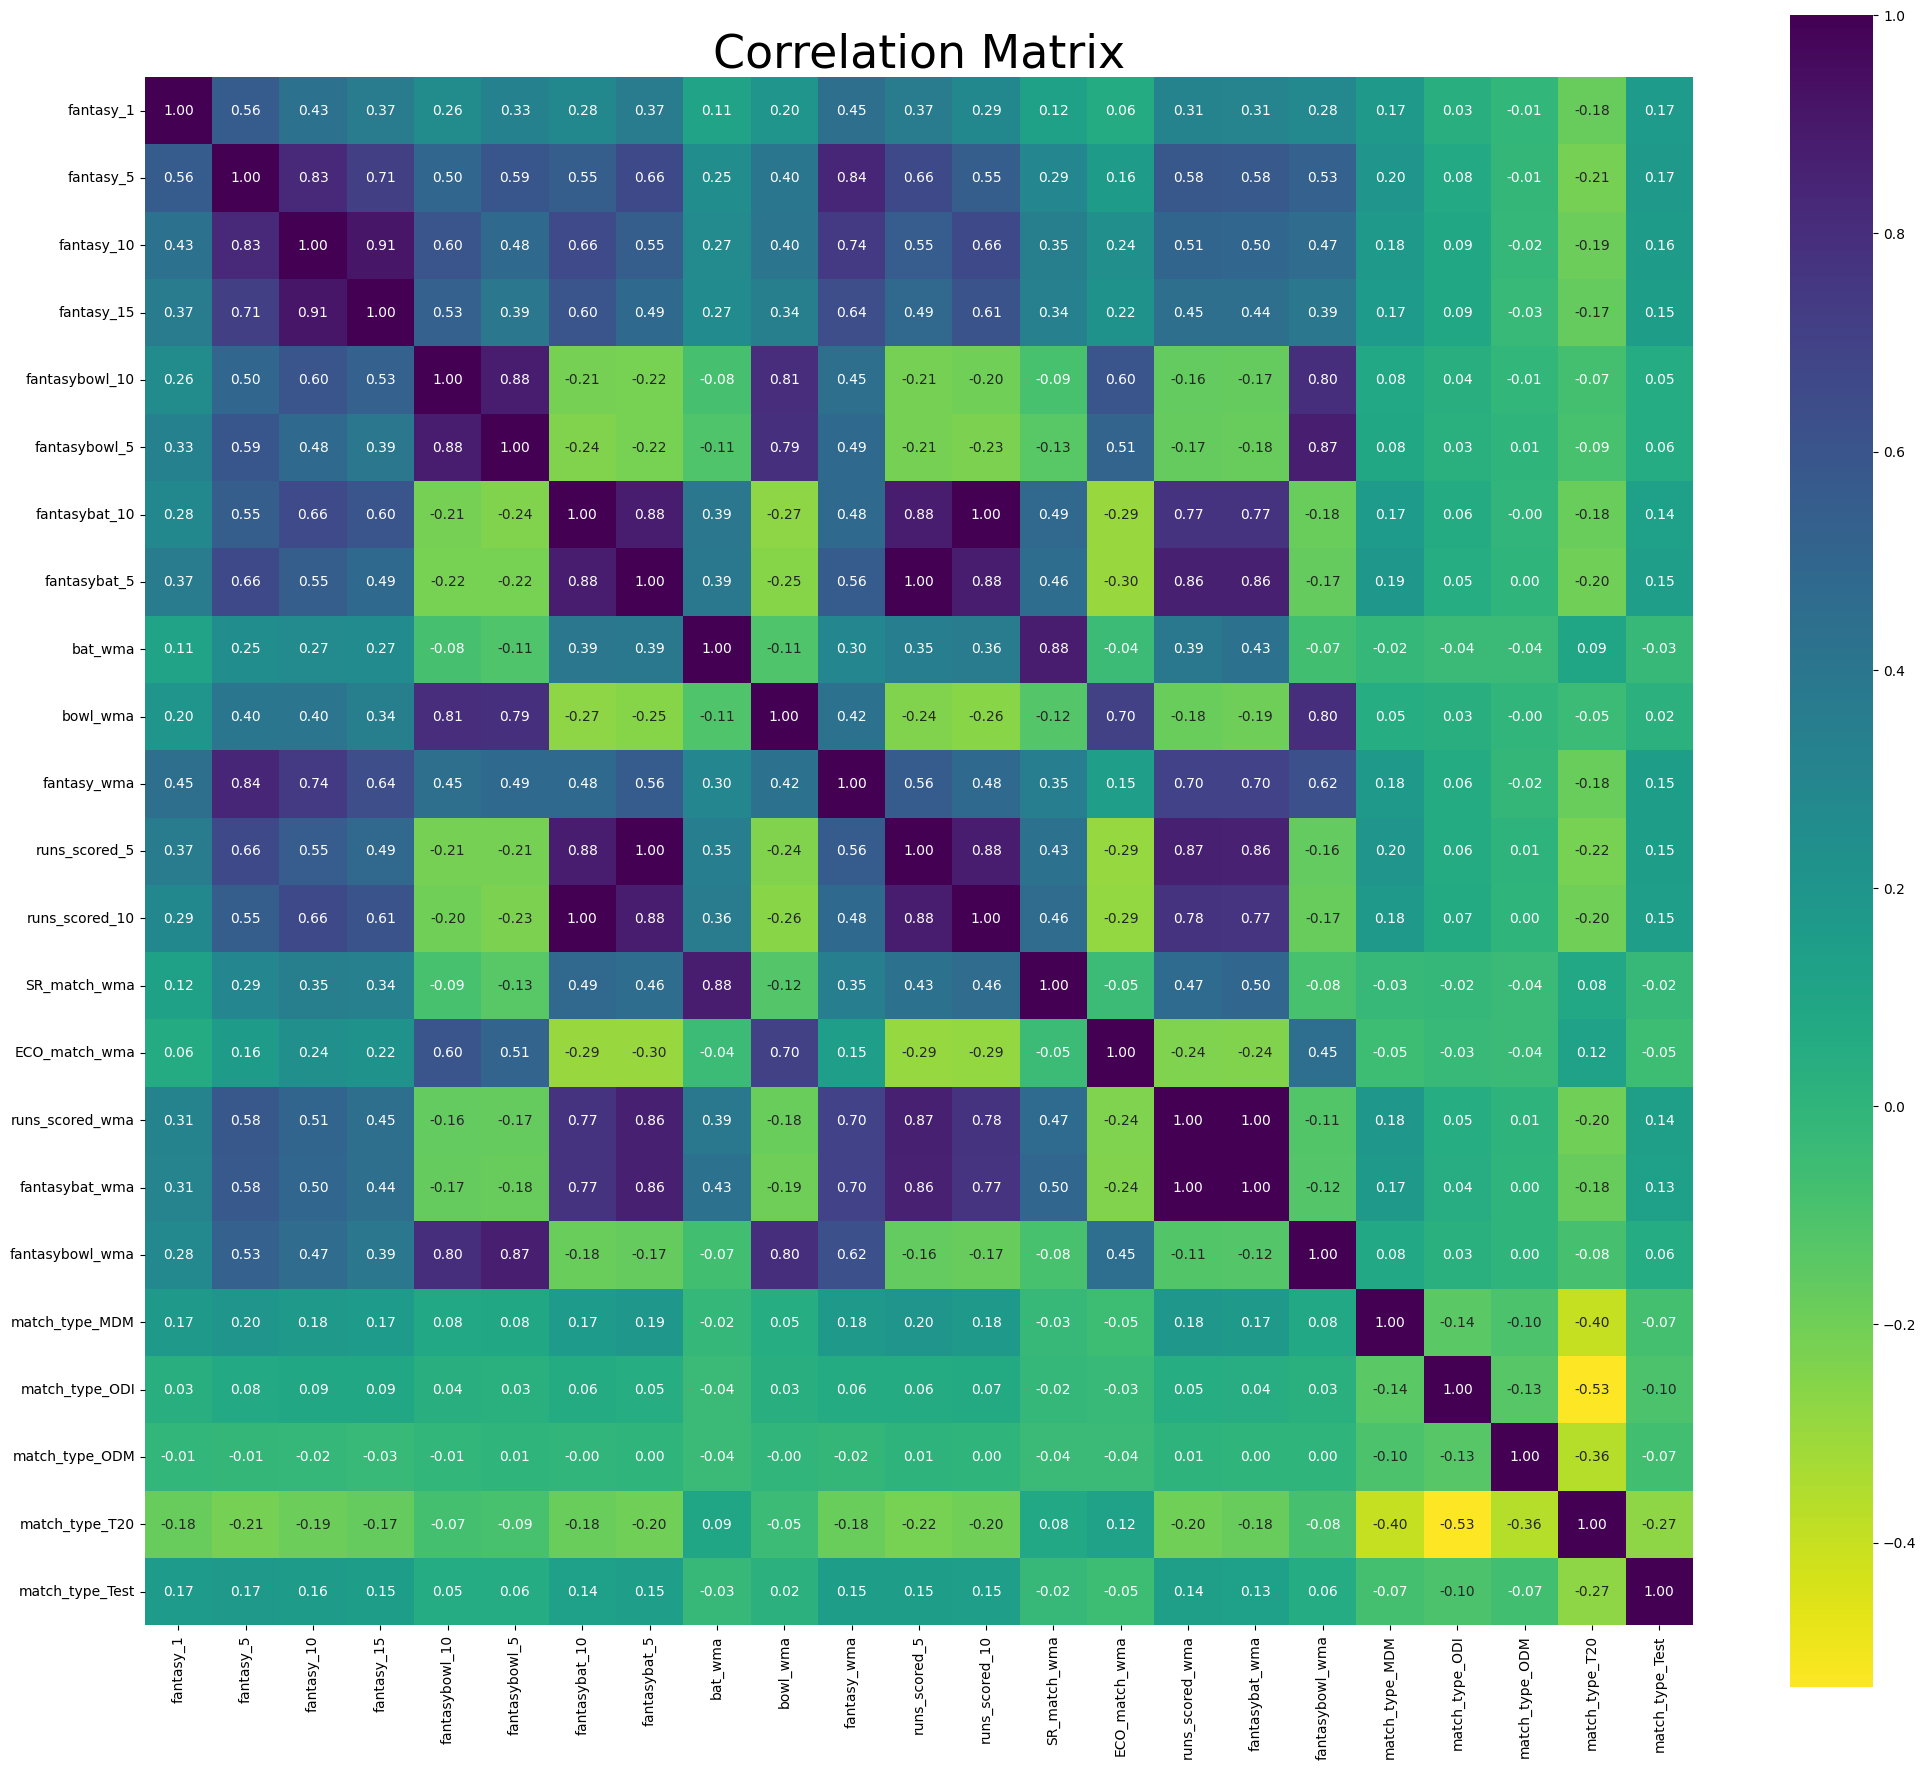

In [16]:
corr_matrix = X_train.corr()
plt.figure(figsize=(21, 18))
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r', fmt='.2f', square=True)
plt.title("Correlation Matrix",fontsize=33)
plt.tight_layout()
plt.show()

In [17]:
X_test

,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,...,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,5.2,46.8,103.0,161.0,36.0,19.2,27.0,3.6,0.000000,0.000000,...,22.805438,0.000000,0.610587,0.912302,0.000042,0,0,0,1,0
1,26.0,66.0,95.0,179.0,52.0,38.4,3.0,3.6,0.000000,0.000000,...,38.769244,0.000000,1.037998,1.550913,2.862661,0,0,0,1,0
2,20.8,61.2,99.0,176.0,44.0,19.2,15.0,18.0,0.000000,0.000000,...,0.000898,0.000000,0.287612,2.146603,4.865666,0,0,0,1,0
3,9.1,78.0,234.0,405.0,158.0,30.0,48.0,24.0,0.190812,0.107370,...,97.700833,11.404444,3.387463,4.164558,-1.741250,0,0,0,1,0
4,78.0,98.4,237.0,457.0,106.0,-2.4,99.0,76.8,0.420703,0.127355,...,164.789096,7.272777,7.755130,13.908138,3.742064,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21107,2.6,266.4,409.0,540.0,82.0,81.6,287.0,160.8,0.401602,0.000000,...,162.750778,0.000000,17.241461,23.909911,9.002283,0,0,0,1,0
21108,5.2,232.8,411.0,539.0,82.0,48.0,289.0,160.8,0.243296,0.000000,...,115.568685,0.000000,19.649017,28.344621,8.272109,0,0,0,1,0
21109,15.6,144.0,397.0,510.0,90.0,38.4,267.0,81.6,0.000011,0.000000,...,0.012813,0.000000,0.001842,-1.033366,1.431323,0,0,0,1,0
21110,63.7,171.6,352.0,493.0,98.0,38.4,214.0,109.2,0.082573,0.000000,...,34.413829,0.000000,4.476447,6.620497,3.864341,0,0,0,1,0


In [18]:
X_train 

,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,...,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0
1,42.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0
2,5.2,44.4,0.0,0.0,0.0,39.6,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0
3,37.7,79.2,0.0,0.0,0.0,69.6,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0
4,1.3,80.4,0.0,0.0,0.0,62.4,0.0,3.6,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395595,85.8,205.2,185.0,0.0,40.0,48.0,121.0,133.2,0.198277,0.000000,...,112.319863,3.953308,11.966646,17.565394,5.295429,0,0,0,1,0
395596,2.6,158.4,187.0,0.0,40.0,28.8,119.0,105.6,0.337056,0.000000,...,146.984679,6.720624,19.462165,28.623796,9.001543,0,0,0,1,0
395597,22.1,157.2,204.0,0.0,40.0,28.8,132.0,104.4,0.239319,0.037661,...,121.283771,1.412279,17.475590,25.498342,8.271705,0,0,0,1,0
395598,2.6,153.6,206.0,206.0,40.0,28.8,130.0,100.8,0.055302,0.064023,...,30.420991,2.401341,3.347679,2.562665,0.000235,0,0,0,1,0


# Training on XG-BOOST MODEL

In [19]:
from xgboost import XGBRegressor
# Training the model
model = XGBRegressor(n_estimators=190, learning_rate=0.15, max_depth=15, random_state=42)
model.fit(X_train, y_train)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


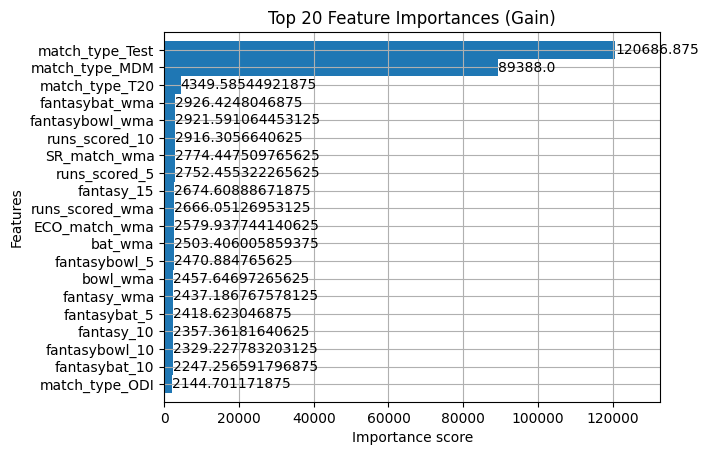

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, importance_type='gain', max_num_features=20, height=1)
plt.title('Top 20 Feature Importances (Gain)')
plt.show()


In [21]:
importances = model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp_df.head(10))


            feature  importance
22  match_type_Test    0.459640
18   match_type_MDM    0.340437
21   match_type_T20    0.016566
16   fantasybat_wma    0.011145
17  fantasybowl_wma    0.011127
12   runs_scored_10    0.011107
13     SR_match_wma    0.010567
11    runs_scored_5    0.010483
3        fantasy_15    0.010186
15  runs_scored_wma    0.010154


In [22]:
print(X_train.shape)

(395600, 23)


In [23]:
# Predict
fantasy_score_total_predicted = model.predict(X_test)

### PLOT OF ACTUAL VS PREDICTED FANTASY SCORE

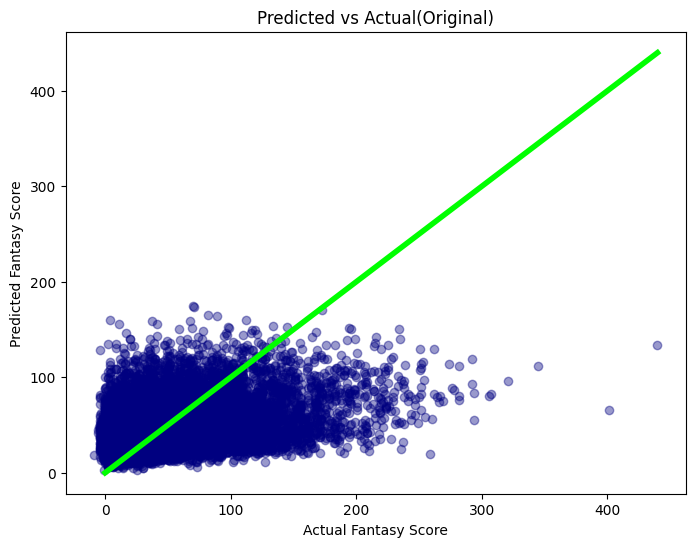

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, fantasy_score_total_predicted, alpha=0.4,color='navy')
plt.xlabel("Actual Fantasy Score")
plt.ylabel("Predicted Fantasy Score")
plt.title("Predicted vs Actual(Original)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='lime',linewidth=4)  # perfect line
plt.show()


In [25]:
# Creating a DataFrame with actual and predicted fantasy_score_total
df_predictions = pd.DataFrame({
    'player_id': df_test_features['player_id'],
    'match_id': df_test_features['match_id'],
    'fantasy_score_total': df_test_features['fantasy_score_total'],
    'fantasy_score_total_predicted': fantasy_score_total_predicted
})
df_predictions.head()

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,2,1474423,20,13.020783
1,2,1474424,16,16.157978
2,2,1474429,2,19.417217
3,4,1443059,60,25.668915
4,4,1443062,22,36.681198


In [26]:
def mape_sum_top11_per_match(group):
    actual_top11_sum = group.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum()
    predicted_top11_sum = group.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum()
    
    # Avoid division by zero
    if actual_top11_sum == 0:
        return np.nan
    
    return abs(actual_top11_sum - predicted_top11_sum) / actual_top11_sum * 100
mape_by_match = df_predictions.groupby('match_id')[['fantasy_score_total', 'fantasy_score_total_predicted']].apply(mape_sum_top11_per_match)
mape = mape_by_match.mean()

In [27]:
print(f" MAPE: {mape:.2f} %")

 MAPE: 27.56 %


In [28]:
Top11_df = (
    df_predictions.groupby('match_id').apply(
        lambda x: pd.Series({
            'sum_top11_actual': x.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum().round(0),
            'sum_top11_predict': x.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum().round(0)
        })
    ).reset_index()
)
Top11_df['sum_top11_actual'] = Top11_df['sum_top11_actual'].astype(int)
Top11_df['sum_top11_predict'] = Top11_df['sum_top11_predict'].astype(int)


C:\Users\abhau\AppData\Local\Temp\ipykernel_14624\1313617572.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_predictions.groupby('match_id').apply(


In [29]:
df_predictions # PREDICTIONS FOR INDIVIDUAL PLAYERS

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,2,1474423,20,13.020783
1,2,1474424,16,16.157978
2,2,1474429,2,19.417217
3,4,1443059,60,25.668915
4,4,1443062,22,36.681198
...,...,...,...,...
21107,11770,1473475,4,25.097876
21108,11770,1473478,12,26.670605
21109,11770,1473482,49,35.653938
21110,11770,1473487,4,29.384476


In [30]:
Top11_df

,match_id,sum_top11_actual,sum_top11_predict
0,1421074,832,535
1,1426556,1278,1269
2,1426557,1334,1266
3,1426558,1818,1242
4,1426559,1183,1332
...,...,...,...
946,1484052,762,507
947,1485778,649,492
948,1486225,846,443
949,1486227,688,455


# USING PARTICLE SWARM OPTIMIATION (PSO) TO MINIMIZE MAPE ACROSS TOP 11 TOTALS
 The objective function scales the predictions by a single weight factor

In [31]:
from pyswarm import pso

def mape_PSO(w, df):
    scaled_pred = df['sum_top11_predict'] * w[0]
    mape = mean_absolute_percentage_error(df['sum_top11_actual'], scaled_pred)
    return mape * 100

# Function to call PSO

def run_pso(Top11_df, lower_bound=0.2, upper_bound=5.5):
    lb = [lower_bound]  
    ub = [upper_bound]  
    best_weight, best_score = pso(lambda w: mape_PSO(w, Top11_df), lb, ub, swarmsize=30, maxiter=40)
    print(f"\n Optimized weight: {best_weight[0]:.6f}, MAPE: {best_score:.2f} %")
    return best_weight[0], best_score

best_w, best_mape = run_pso(Top11_df)

Stopping search: Swarm best objective change less than 1e-08

 Optimized weight: 1.304189, MAPE: 16.83 %


### -->> AFTER USING PSO, MAPE REDUCED FROM 31 TO 17.25 WHICH IS A HUGE BOOST FOR THE MODEL

In [32]:
df_predictions['fantasy_score_total_predicted_scaled'] = (df_predictions['fantasy_score_total_predicted']* 1.308).round(0).astype(int)
df_predictions['fantasy_score_total_predicted'] = (df_predictions['fantasy_score_total_predicted']).round(0).astype(int)
df_predictions.head(12)

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,fantasy_score_total_predicted_scaled
0,2,1474423,20,13,17
1,2,1474424,16,16,21
2,2,1474429,2,19,25
3,4,1443059,60,26,34
4,4,1443062,22,37,48
5,4,1443065,38,27,35
6,4,1443069,6,46,61
7,4,1443076,13,33,44
8,4,1443080,21,24,31
9,17,1477679,4,19,25


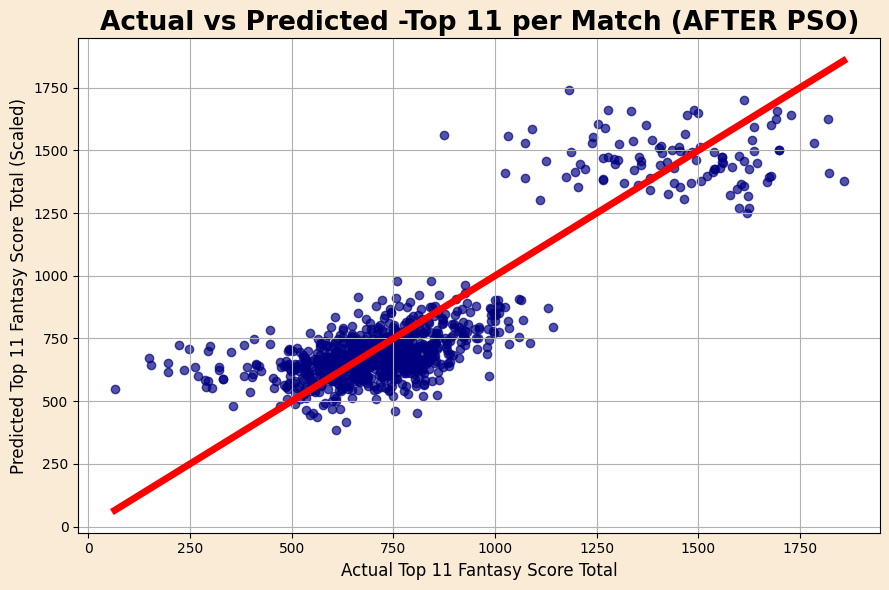

In [33]:
best_weight = 1.308
Top11_df['sum_top11_predict_scaled'] = Top11_df['sum_top11_predict'] * best_weight

plt.figure(figsize=(9, 6),facecolor='antiquewhite')

plt.scatter(Top11_df['sum_top11_actual'], Top11_df['sum_top11_predict_scaled'], alpha=0.68, color='navy')
plt.plot([Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()], [Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()],color='red',linewidth=5)

plt.xlabel('Actual Top 11 Fantasy Score Total', fontsize=12)
plt.ylabel('Predicted Top 11 Fantasy Score Total (Scaled)', fontsize=12)
plt.title('Actual vs Predicted -Top 11 per Match (AFTER PSO)', fontsize=19,fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
Top11_df

,match_id,sum_top11_actual,sum_top11_predict,sum_top11_predict_scaled
0,1421074,832,535,699.780
1,1426556,1278,1269,1659.852
2,1426557,1334,1266,1655.928
3,1426558,1818,1242,1624.536
4,1426559,1183,1332,1742.256
...,...,...,...,...
946,1484052,762,507,663.156
947,1485778,649,492,643.536
948,1486225,846,443,579.444
949,1486227,688,455,595.140


In [35]:
match_type_cols = [col for col in df.columns if col.startswith("match_type_")]
print(match_type_cols)

['match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test']


In [36]:
df_t20 = df[df['match_type_T20'] == 1].copy()
df_odi = df[df['match_type_ODI'] == 1].copy()
df_test = df[df['match_type_Test'] == 1].copy()
df_odm = df[df['match_type_ODM'] == 1].copy()
df_mdm = df[df['match_type_MDM'] == 1].copy()

In [37]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

model_xgb = XGBRegressor(n_estimators=200,max_depth=15, learning_rate=0.1,random_state=42)
model_gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_ridge = Ridge(alpha=1.0)

model_xgb.fit(X_train, y_train)
model_gbr.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [38]:
# Predict
y_pred_xgb = model_xgb.predict(X_test)
y_pred_gbr = model_gbr.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("R² Score:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("GradientBoosting", y_test, y_pred_gbr)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)


XGBoost
R² Score: 0.16053509712219238
MAE: 28.62033462524414
RMSE: 38.304599065521

GradientBoosting
R² Score: 0.1983246390038581
MAE: 28.009439151240958
RMSE: 37.432508169068974

Ridge Regression
R² Score: 0.1903443124416424
MAE: 28.267419053162058
RMSE: 37.618358898278245


# STACKED ENSEMBLING

In [39]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# base models
base_learners = [
    ('xgb', XGBRegressor(n_estimators=150, max_depth=9, verbosity=0, n_jobs=-1)),
    ('ridge', make_pipeline(StandardScaler(), Ridge(alpha=0.01))),
    ('gbr', GradientBoostingRegressor(n_estimators=80, random_state=42))
]

# meta-learner
meta_learner = HistGradientBoostingRegressor(max_iter=150, learning_rate=0.1, random_state=42)

# stacking regressor
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,  
    cv=4,
    n_jobs=-1
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict 
y_pred = stacking_model.predict(X_train)

# Evaluate
print("R2 Score:", r2_score(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

from joblib import dump, load

#Loading model
dump(stacking_model, 'stacking_model5.joblib')
stacking_model = load('stacking_model5.joblib')



R2 Score: 0.20099491005516834
MAE: 29.05615461201388
RMSE: 38.661317948512334


### ON TESTING DATA

In [40]:
# Predict on test data
y_test_pred = stacking_model.predict(X_test)

print("R2 Score (Test):", r2_score(y_test, y_test_pred))
print("MAE (Test):", mean_absolute_error(y_test, y_test_pred))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_test_pred)))


R2 Score (Test): 0.1991185167735552
MAE (Test): 27.973055270198845
RMSE (Test): 37.413969370112135


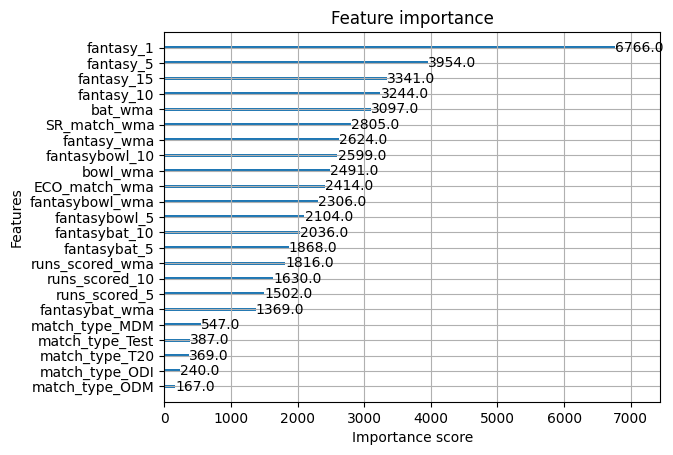

In [41]:
from xgboost import plot_importance

xgb = base_learners[0][1]
xgb.fit(X_train, y_train)
plot_importance(xgb)
plt.show()


In [42]:
df_predictions['predicted_score'] = stacking_model.predict(X_test)
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,fantasy_score_total_predicted_scaled,predicted_score
0,2,1474423,20,13,17,16.111632
1,2,1474424,16,16,21,22.619158
2,2,1474429,2,19,25,17.481491
3,4,1443059,60,26,34,30.489571
4,4,1443062,22,37,48,34.622856
...,...,...,...,...,...,...
21107,11770,1473475,4,25,33,36.204452
21108,11770,1473478,12,27,35,36.087790
21109,11770,1473482,49,36,47,32.967748
21110,11770,1473487,4,29,38,33.418912


In [43]:
from sklearn.metrics import mean_absolute_percentage_error
from pyswarm import pso

df_top11_stack = (
    df_predictions[['match_id', 'player_id', 'predicted_score']] .sort_values(['match_id', 'predicted_score'], ascending=[True, False])  .groupby('match_id').head(11)
    .groupby('match_id')['predicted_score'].sum().reset_index(name='sum_top11_predict'))

# Merge with actuals
df_eval_stack = df_top11_stack.merge(Top11_df, on='match_id')

# Base MAPE
base_mape = mean_absolute_percentage_error(df_eval_stack['sum_top11_actual'], df_eval_stack['sum_top11_predict_x']) * 100

#  Run PSO
def obj(w):
    scaled = df_eval_stack['sum_top11_predict_x'] * w[0]
    return mean_absolute_percentage_error(df_eval_stack['sum_top11_actual'], scaled) * 100

best_w, best_mape = pso(obj, [1.1], [2.5], swarmsize=10, maxiter=200, debug=False)
print(f"[Stacking] Base MAPE: {base_mape:.2f}% | PSO MAPE: {best_mape:.2f}% | Best Weight: {best_w[0]:.4f}")

Stopping search: Swarm best objective change less than 1e-08
[Stacking] Base MAPE: 33.04% | PSO MAPE: 16.23% | Best Weight: 1.4394


## Top 11 Mape after PSO of Stacked Ensembling Model is 16.17% :)

In [44]:
df_predictions['Stacked_Score_PSO'] = df_predictions['predicted_score'] * 1.4367
df_predictions.columns

Index(['player_id', 'match_id', 'fantasy_score_total',
       'fantasy_score_total_predicted', 'fantasy_score_total_predicted_scaled',
       'predicted_score', 'Stacked_Score_PSO'],
      dtype='object')

#### Creating a dataframe to compare stacked+PSO predicted scores with actual

In [45]:
cols_to_drop = ['fantasy_score_total_predicted', 'fantasy_score_total_predicted_scaled','final_score','final_score_Stacked']
df_stacked = df_predictions.drop(columns=cols_to_drop, errors='ignore').round(0)

df_stacked

,player_id,match_id,fantasy_score_total,predicted_score,Stacked_Score_PSO
0,2,1474423,20,16.0,23.0
1,2,1474424,16,23.0,32.0
2,2,1474429,2,17.0,25.0
3,4,1443059,60,30.0,44.0
4,4,1443062,22,35.0,50.0
...,...,...,...,...,...
21107,11770,1473475,4,36.0,52.0
21108,11770,1473478,12,36.0,52.0
21109,11770,1473482,49,33.0,47.0
21110,11770,1473487,4,33.0,48.0


In [46]:
top11_df = (
    df_stacked
    .groupby('match_id')
    .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO'))
    .reset_index(drop=True)
)

C:\Users\abhau\AppData\Local\Temp\ipykernel_14624\2963418355.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO'))


In [47]:
# Top-11 predicted total per match using Stacked_Score_PSO
df_top11_sum = (
    df_stacked
    .groupby('match_id')
    .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO')['Stacked_Score_PSO'].sum())
    .reset_index(name='sum_top11_predict')
)

# Merge with actual Top-11 scores
df_top11_eval = df_top11_sum.merge(
    Top11_df[['match_id', 'sum_top11_actual']], 
    on='match_id'
)

C:\Users\abhau\AppData\Local\Temp\ipykernel_14624\3883572081.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO')['Stacked_Score_PSO'].sum())


In [48]:
df_stacked

,player_id,match_id,fantasy_score_total,predicted_score,Stacked_Score_PSO
0,2,1474423,20,16.0,23.0
1,2,1474424,16,23.0,32.0
2,2,1474429,2,17.0,25.0
3,4,1443059,60,30.0,44.0
4,4,1443062,22,35.0,50.0
...,...,...,...,...,...
21107,11770,1473475,4,36.0,52.0
21108,11770,1473478,12,36.0,52.0
21109,11770,1473482,49,33.0,47.0
21110,11770,1473487,4,33.0,48.0


### Comparing ACTUAL VS PREDICTED FANTASY SCORE OF TOP 11 IN A RANDOM MATCH

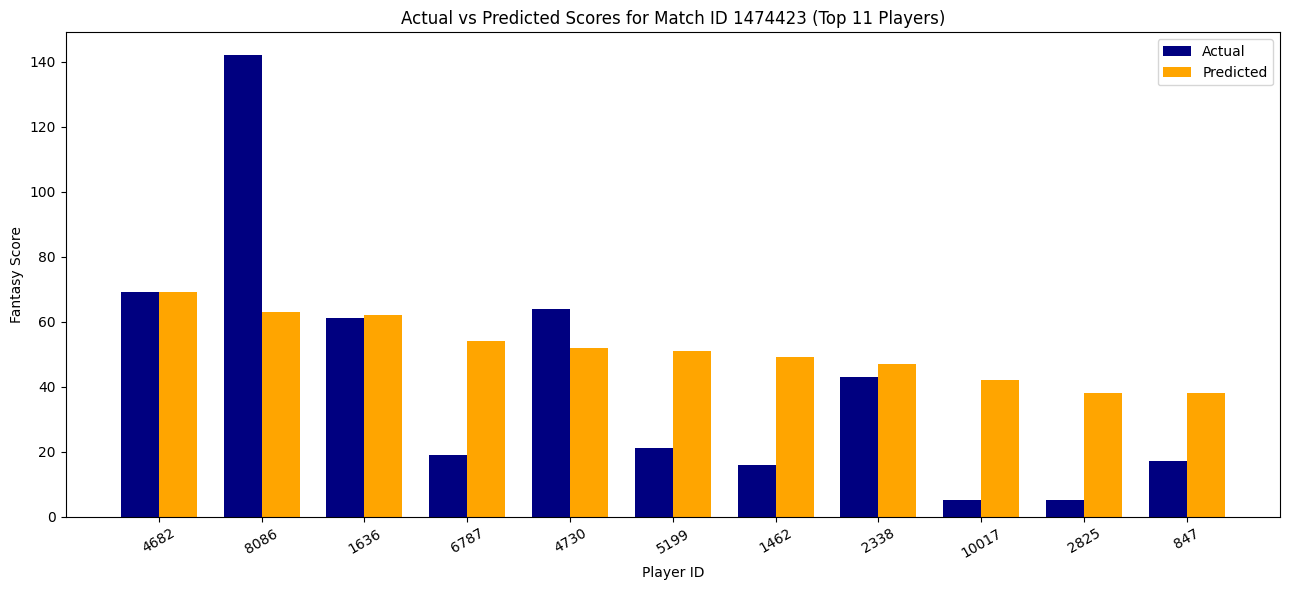

In [49]:
df_stacked['match_id'] = df_stacked['match_id'].astype(str)
match_id = '1474423' 

# Get top 11 players for the match
df_match = (
    df_stacked[df_stacked['match_id'] == match_id] .sort_values('Stacked_Score_PSO', ascending=False).head(11))

player_ids = df_match['player_id'].astype(str).tolist()
actual_scores = df_match['fantasy_score_total'].tolist()
predicted_scores = df_match['Stacked_Score_PSO'].tolist()

#Plot
x = np.arange(len(player_ids))
width = 0.37

plt.figure(figsize=(13, 6))
plt.bar(x - width/2, actual_scores, width, label='Actual', color='navy')
plt.bar(x + width/2, predicted_scores, width, label='Predicted', color='orange')

plt.xlabel('Player ID')
plt.ylabel('Fantasy Score')
plt.title(f'Actual vs Predicted Scores for Match ID {match_id} (Top 11 Players)')
plt.xticks(x, player_ids, rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


### Actual vs Predicted Total Top 11 Fantasy Scores

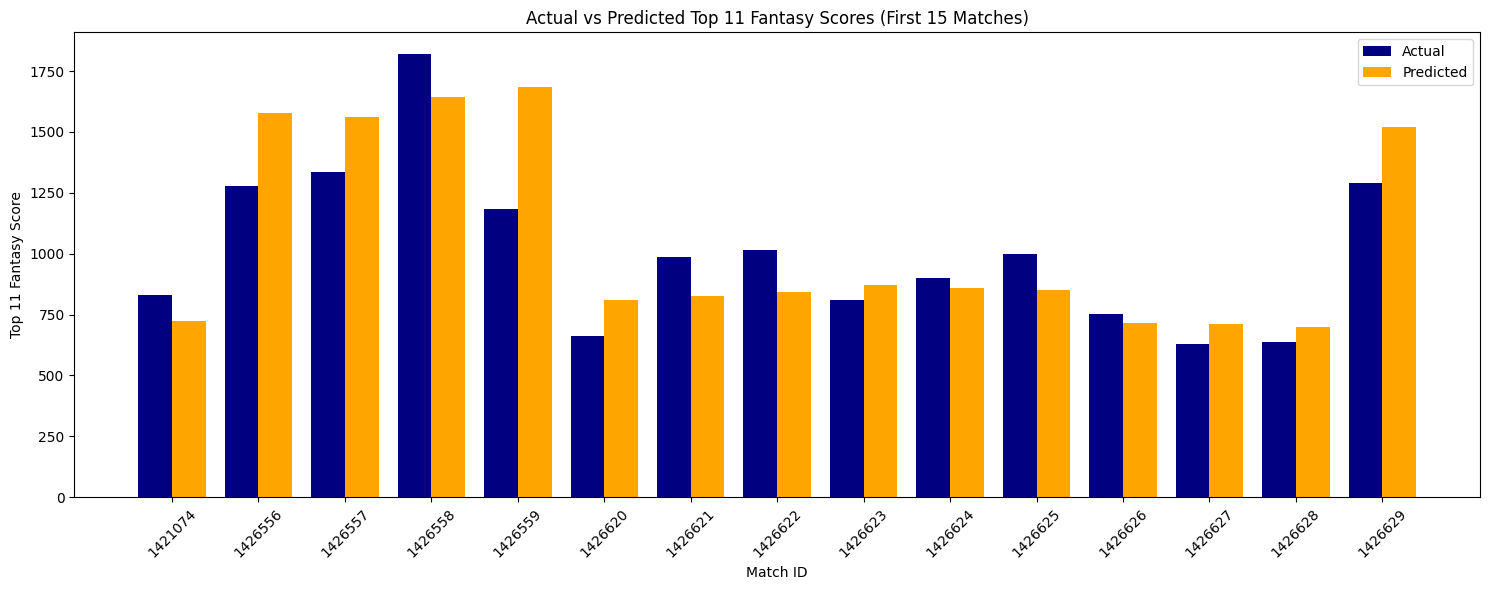

In [50]:
# only first 15 rows
set = df_top11_eval.head(15)

# Data
matches = set['match_id'].astype(str).tolist()
actual = set['sum_top11_actual'].tolist()
predicted = set['sum_top11_predict'].tolist()

x = np.arange(len(matches))
width = 0.39

# Plot
plt.figure(figsize=(15, 6))
plt.bar(x - width/2, actual, width, label='Actual', color='navy')
plt.bar(x + width/2, predicted, width, label='Predicted', color='orange')
plt.xlabel('Match ID')
plt.ylabel('Top 11 Fantasy Score')
plt.title('Actual vs Predicted Top 11 Fantasy Scores (First 15 Matches)')
plt.xticks(x, matches, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
df_top11_eval # FOR TOP 11 TEAMS

,match_id,sum_top11_predict,sum_top11_actual
0,1421074,725.0,832
1,1426556,1579.0,1278
2,1426557,1563.0,1334
3,1426558,1642.0,1818
4,1426559,1684.0,1183
...,...,...,...
946,1484052,646.0,762
947,1485778,645.0,649
948,1486225,595.0,846
949,1486227,651.0,688


In [52]:
!pip install feast